In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

from keras.callbacks import EarlyStopping, TensorBoard
from keras.layers import Dense
from keras.models import Sequential
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

from tqdm import tqdm
import numpy as np
import random
import pickle as pkl

import matplotlib.pyplot as plt

In [20]:
dataset = pd.read_csv('/kaggle/input/mushroom-classification/mushrooms.csv')

In [21]:
unique_counts = dataset.nunique()

# Exploratory Data Analysis

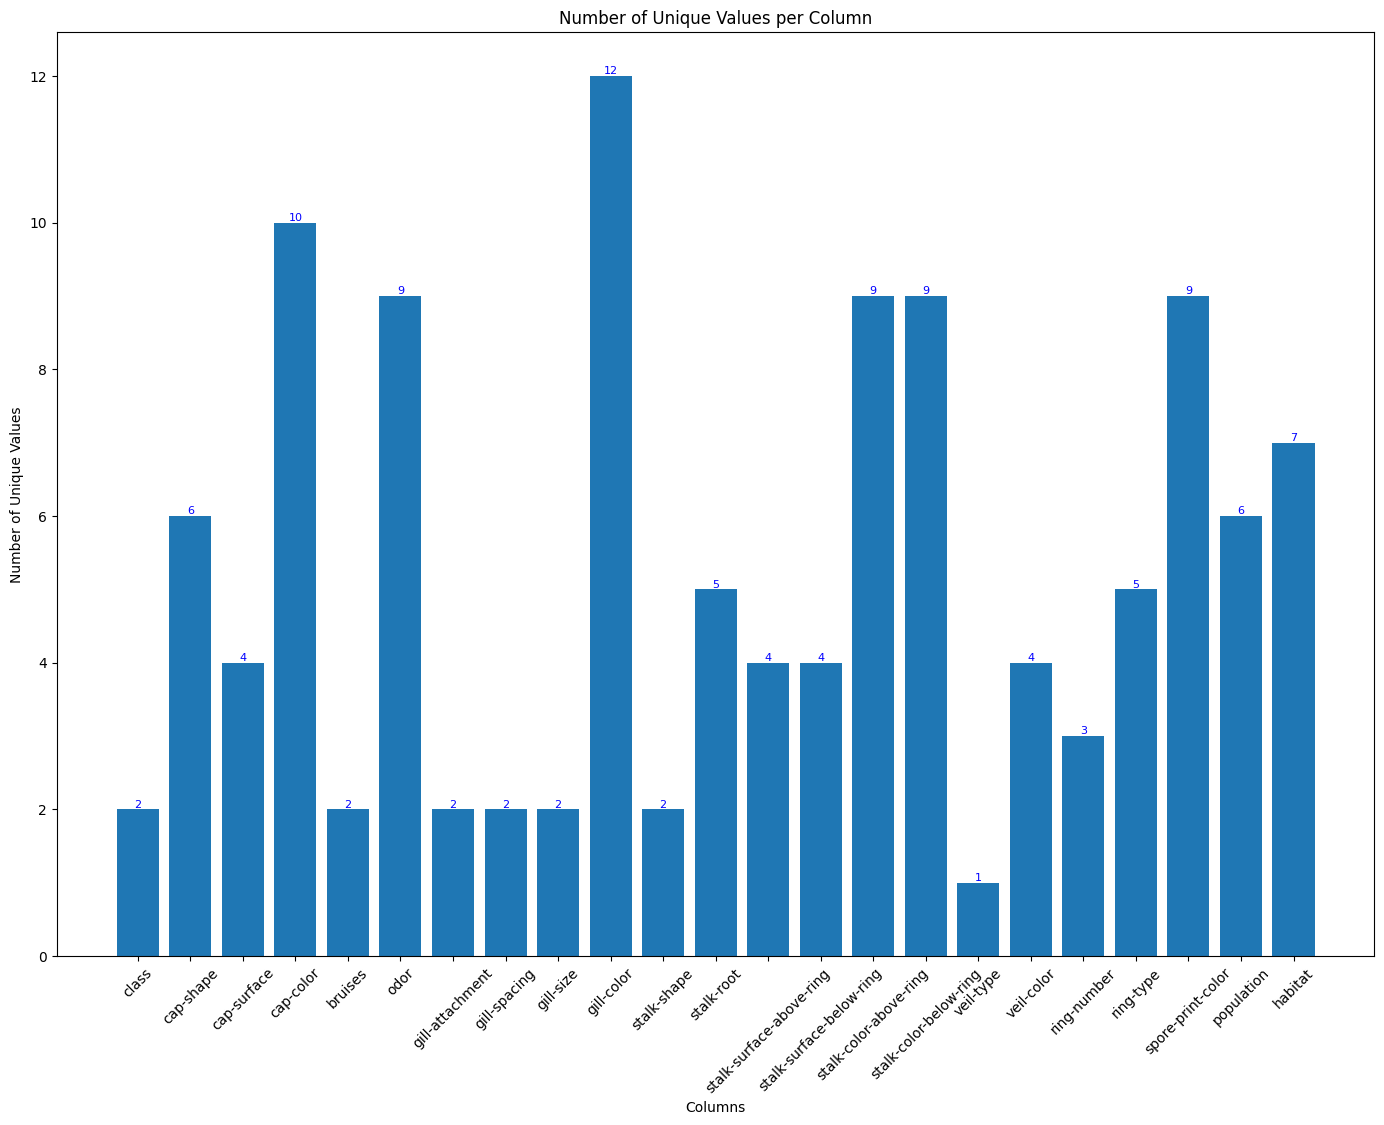

In [22]:
plt.figure(figsize=(17, 12))  # Adjust the figure size as needed
bars = plt.bar(unique_counts.index, unique_counts.values)

# Adding labels and title
plt.xlabel('Columns')
plt.ylabel('Number of Unique Values')
plt.title('Number of Unique Values per Column')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Adding annotations on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom', ha='center', color='blue', fontsize=8)

# Show the plot
plt.show()

In [23]:
labels = ['Edible', 'Poisonous']
values = [dataset.describe()['class']['freq'], dataset.describe()['class']['count']-dataset.describe()['class']['freq']]
colors = ['green', 'red']

fig = go.Figure(data=[go.Pie(labels=labels, values=values, opacity=0.8)])
fig.update_traces(textinfo='percent+label', marker=dict(line=dict(color='#000000', width=2), colors=colors))
fig.update_layout(title_text='Distribution of the Mushrooms by their Classes', title_x=0.5, title_font=dict(size=28))
fig.show()

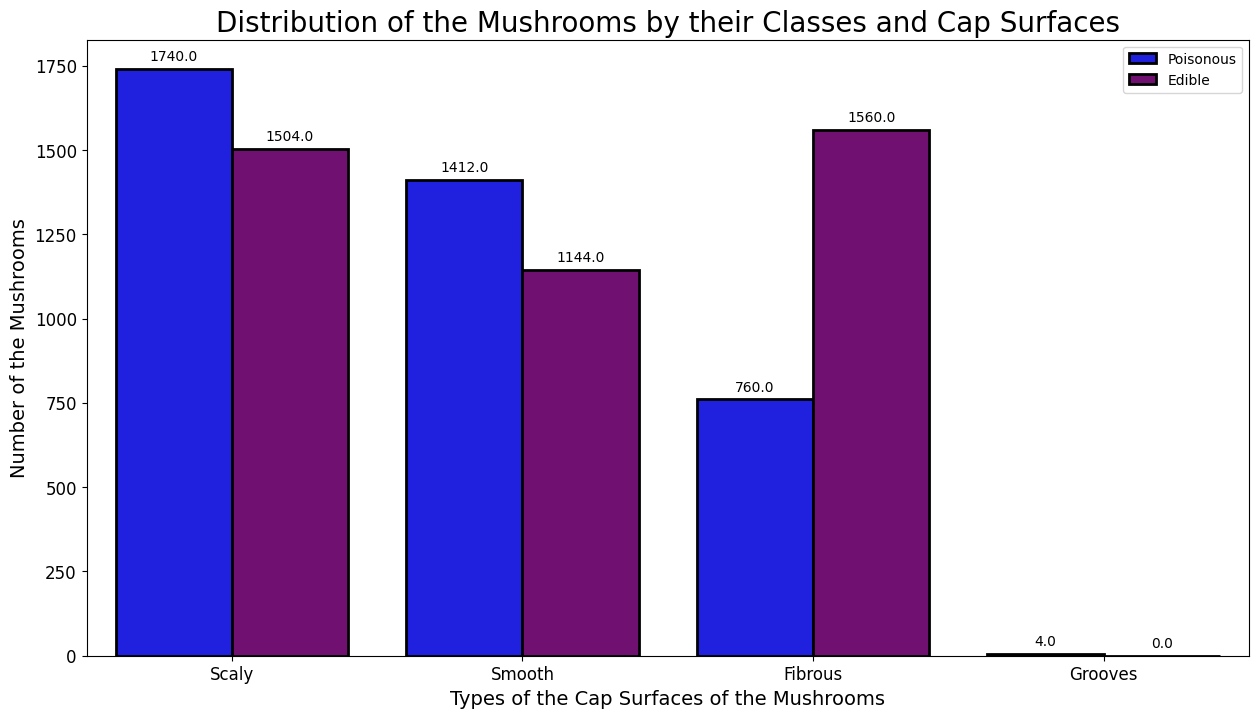

In [24]:
plt.figure(figsize=(15, 8))
splot = sns.countplot(data=dataset, x='cap-surface',
                      hue='class',  
                      order=dataset['cap-surface'].value_counts().index,
                      palette=['blue', 'purple'],  
                      edgecolor=(0, 0, 0),
                      linewidth=2)
                      
splot.set_xticklabels(['Scaly', 'Smooth', 'Fibrous', 'Grooves'])

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center',
                   xytext=(0, 9),
                   textcoords='offset points')

plt.legend(['Poisonous', 'Edible'], loc='upper right')
plt.ylabel('Number of the Mushrooms', fontsize=14)
plt.xlabel('Types of the Cap Surfaces of the Mushrooms', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Distribution of the Mushrooms by their Classes and Cap Surfaces', fontsize=20)

plt.show()

In [25]:


y_train = dataset['class']
x_train = dataset.drop(labels=['class'], axis=1)

le = LabelEncoder()

cols = x_train.columns.values
for col in cols:
    x_train[col] = le.fit_transform(x_train[col])

y_train = le.fit_transform(y_train)

# Create an instance of OneHotEncoder with the 'categories' parameter
ohe = OneHotEncoder(categories='auto', sparse=False)

x_train = ohe.fit_transform(x_train)
sc = StandardScaler()
x_train = sc.fit_transform(x_train)

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.30, random_state=42)
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, test_size=0.50, random_state=42)


In [26]:
def sigmoid(x):
    return 1/(1 + np.exp(-x)) 

def relu(x):
    return np.maximum(0, x)

def forward(x, w, activation):
    return activation(np.matmul(x, w))

def accuracy_fn(y, y_hat):
    return (np.where(y == y_hat)[0].size / y_hat.size)

def predict(x, y_hat, weights, activation):
    predictions = np.zeros(shape=(x.shape[0]))
    
    for idx in range(x.shape[0]):
        r1 = x[idx, :]
        for curr_weights in weights:
            r1 = forward(r1, curr_weights, activation)
        predictions[idx] = np.where(r1 == np.max(r1))[0][0]

    accuracy = accuracy_fn(predictions, y_hat)
    return accuracy, predictions
    
def fitness(x, y_hat, weights, activation):
    accuracy = np.empty(shape=(weights.shape[0]))
    for idx in range(weights.shape[0]):
        accuracy[idx], _ = predict(x, y_hat, weights[idx, :], activation)
    return accuracy

### Vector-Matrix Manipulations

In [27]:
def mat_to_vector(mat_pop_weights):
    weights_vector = []
    for idx in range(mat_pop_weights.shape[0]):
        curr_vector = []
        for layer_idx in range(mat_pop_weights.shape[1]):
            vector_weights = np.reshape(mat_pop_weights[idx, layer_idx], newshape=(mat_pop_weights[idx, layer_idx].size))
            curr_vector.extend(vector_weights)
        weights_vector.append(curr_vector)
    return np.array(weights_vector)


def vector_to_mat(vector_weights, mat_pop_weights):
    mat_weights = []
    for idx in range(mat_pop_weights.shape[0]):
        start = 0
        end = 0
        for layer_idx in range(mat_pop_weights.shape[1]):
            end = end + mat_pop_weights[idx, layer_idx].size
            curr_vector = vector_weights[idx, start:end]
            mat_layer_weights = np.reshape(curr_vector, newshape=(mat_pop_weights[idx, layer_idx].shape))
            mat_weights.append(mat_layer_weights)
            start = end
    return np.reshape(mat_weights, newshape=mat_pop_weights.shape)

In [28]:
def mating_pool(pop, fitness, num_parents):
    parents = np.empty((num_parents, pop.shape[1]))
    for parent_num in range(num_parents):
        max_fitness_idx = np.where(fitness == np.max(fitness))
        max_fitness_idx = max_fitness_idx[0][0]
        parents[parent_num, :] = pop[max_fitness_idx, :]
        fitness[max_fitness_idx] = -99
    return parents


def crossover(parents, offspring_size):
    offspring = np.empty(offspring_size)
    crossover_point = np.uint32(offspring_size[1]/2)

    for k in range(offspring_size[0]):
        
        parent1_idx = k%parents.shape[0]
        parent2_idx = (k+1)%parents.shape[0]
        
        offspring[k, 0:crossover_point] = parents[parent1_idx, 0:crossover_point]
        offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]
        
    return offspring


def mutation(offspring_crossover, mutation_percent):
    num_mutations = np.uint32((mutation_percent*offspring_crossover.shape[1]))
    mutation_indices = np.array(random.sample(range(0, offspring_crossover.shape[1]), num_mutations))
    
    for idx in range(offspring_crossover.shape[0]):
        random_value = np.random.uniform(-1.0, 1.0, 1)
        offspring_crossover[idx, mutation_indices] = offspring_crossover[idx, mutation_indices] + random_value
    
    return offspring_crossover

### Parameters

In [29]:
solution_per_population = 8
num_parents_mating = 4
num_generations = 100
mutation_percent = 0.20

In [30]:
input_shape = x_train.shape[1]
output_shape = len(np.unique(y_train))

### Initial weights

In [31]:
initial_weights = []
for curr_sol in np.arange(0, solution_per_population):
    
    w1 = np.random.uniform(low=-0.1, high=0.1, size=(input_shape, 128))
    w2 = np.random.uniform(low=-0.1, high=0.1, size=(128, 64))
    w3 = np.random.uniform(low=-0.1, high=0.1,size=(64, output_shape))

    initial_weights.append(np.array([w1, w2, w3]))

In [32]:
weights_mat = np.array(initial_weights)
weights_vector = mat_to_vector(weights_mat)

best_outputs = []
accuracies = np.empty(shape=(num_generations))

In [33]:
for generation in tqdm(range(num_generations)):

    # vector to matrix
    weights_mat = vector_to_mat(weights_vector, weights_mat)

    # fitness of the population
    fit = fitness(x_train, y_train, weights_mat, activation=sigmoid)
    
    # assign first fitness to the array
    accuracies[generation] = fit[0]

    # selecting mating parents from pool
    parents = mating_pool(weights_vector, fit.copy(), num_parents_mating)

    # generate new population using crossover
    offspring_crossover = crossover(parents, offspring_size=(weights_vector.shape[0]-parents.shape[0], weights_vector.shape[1]))

    # adding mutation to the population
    offspring_mutation = mutation(offspring_crossover, mutation_percent=mutation_percent)
    
    # new population combining parents of crossver and mut
    weights_vector[0:parents.shape[0], :] = parents
    weights_vector[parents.shape[0]:, :] = offspring_mutation

100%|██████████| 100/100 [12:01<00:00,  7.22s/it]


In [34]:
weights_mat = vector_to_mat(weights_vector, weights_mat)
best_weights = weights_mat [0, :]
acc, predictions = predict(x_train, y_train, best_weights, sigmoid)
print("Accuracy of the best solution is : ", acc)

Accuracy of the best solution is :  0.9199788955328878


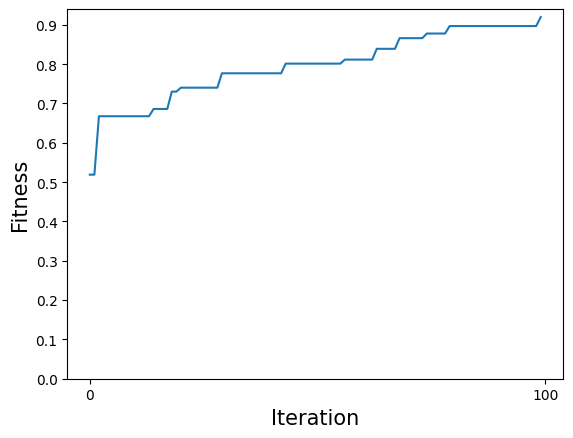

In [35]:
plt.plot(accuracies)
plt.xlabel("Iteration", fontsize=15)
plt.ylabel("Fitness", fontsize=15)
plt.xticks(np.arange(0, num_generations+1, 100))
plt.yticks(np.arange(0, 1, 0.1))
plt.show()

### Test predictions

In [36]:
weights_mat = vector_to_mat(weights_vector, weights_mat)
best_weights = weights_mat [0, :]
acc, predictions = predict(x_test, y_test, best_weights, sigmoid)
print("Accuracy of the best solution is : ", acc)

Accuracy of the best solution is :  0.9286300246103364
